<h2><center><B>AI Use Case</B></center></h2>
<h3><center><b>Assignment 4</b></center></h3>
<h4><center><b>Part 1</b></center></h4>


<P>Build an emotion recognition system using Neural Networks.</P>
<P>Hint: You can use any pre trained models</P>

# **PART 1 : Train and Save Model**

##Import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
#import keras
import os
#from matplotlib import pyplot
import matplotlib.pyplot as plt
#import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
#warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.metrics import accuracy_score
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/AI/fer2013.csv')
data.shape

(35887, 3)

###Exploratory Data Analysis (EDA) 

In [ ]:
data.sample(10)

,emotion,pixels,Usage
26918,4,89 91 105 140 87 96 126 116 134 136 119 125 11...,Training
26413,4,180 133 85 75 63 63 66 67 66 58 51 66 84 102 1...,Training
8652,3,234 234 234 234 234 234 234 227 202 209 224 22...,Training
6674,0,62 69 87 94 100 98 94 91 96 92 94 95 96 94 90 ...,Training
32406,5,170 171 181 172 174 182 188 198 186 180 178 18...,PrivateTest
8919,6,202 207 182 112 143 160 143 104 85 69 64 69 71...,Training
22997,2,42 37 54 80 119 129 139 153 157 166 179 187 19...,Training
22745,6,195 194 195 196 197 198 198 198 198 198 198 19...,Training
26257,3,234 234 233 231 231 232 234 236 238 242 244 24...,Training
31147,5,128 131 132 135 139 144 145 149 149 152 158 16...,PublicTest


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
# verifying the emotion values
data['emotion'].value_counts(sort=False)

0    4953
2    5121
4    6077
6    6198
3    8989
5    4002
1     547
Name: emotion, dtype: int64

In [ ]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
# seven categories of facial expression (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
emotion_label  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sadness', "Surprise", 'Neutral']
fig = px.bar(x = emotion_label,
             y = [list(data['emotion']).count(i) for i in np.unique(data['emotion'])] , 
             color = np.unique(data['emotion']) ,
             color_continuous_scale="sunset") 
fig.update_xaxes(title="Emotions")
fig.update_yaxes(title = "Number of Images")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Train Data Distribution ',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

###Display Sample Images from Training Dataset 

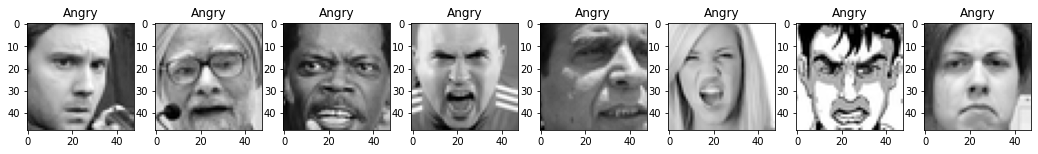

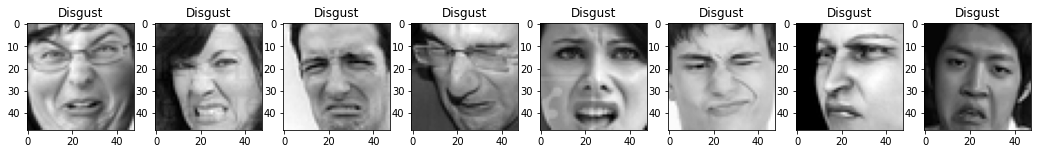

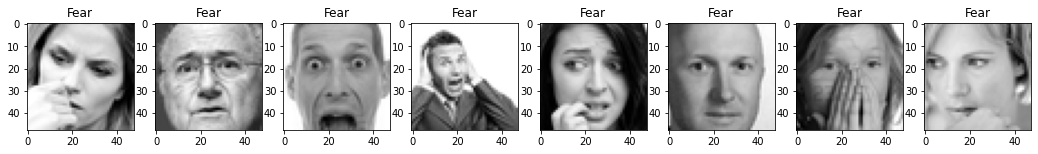

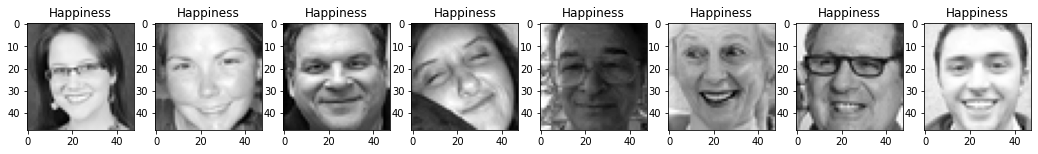

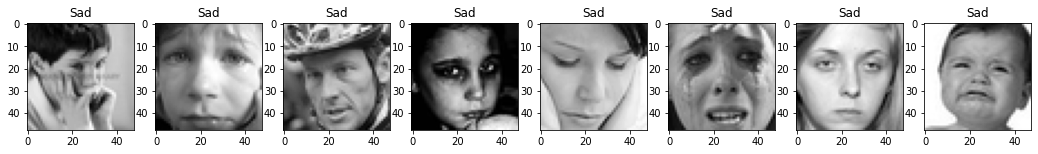

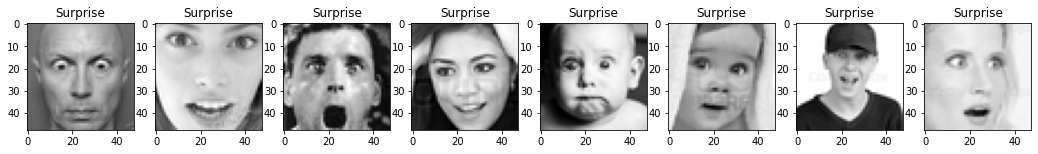

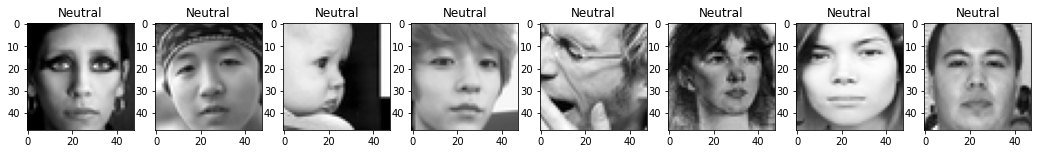

In [ ]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
emotions=0
for emotions in range (7):
  Sample=data.loc[(data.Usage=="Training") & (data.emotion==emotions)]
  Sample.reset_index(drop=True, inplace=True)
  plt.figure(figsize=(18,10))
  i = 0
  for i in range (8):
    img = np.array(Sample.pixels.loc[i].split(' ')).reshape(48,48).astype('float')
    plt.subplot(1,8,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(label_dict[emotions])
  plt.show()

###Data Preparation


**Split Dataset**

In [ ]:
train_set = data[(data.Usage == 'Training')] 
val_set = data[(data.Usage == 'PublicTest')]
test_set = data[(data.Usage == 'PrivateTest')] 

**Reshaping the data 48,48**

In [ ]:
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32)
X_train = X_train/255
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32)
X_val = X_val/255
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32)
X_test = X_test/255
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1), (3589, 48, 48, 1))

In [ ]:
y_train = train_set.emotion
y_train = to_categorical(y_train, num_classes=7)
y_val = val_set.emotion
y_val = to_categorical(y_val, num_classes=7)
y_test = test_set.emotion
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((28709, 7), (3589, 7), (3589, 7))

**Data augmentation using ImageDataGenerator**

In [ ]:
datagen = ImageDataGenerator( 
                            rotation_range=20,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            shear_range=0.2,
                            horizontal_flip = True,
                            zoom_range = 0.2,
                            fill_mode = 'nearest')

In [ ]:
datagen.fit(X_train)

In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=32)

##Build CNN Model

In [ ]:
model= Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
      
model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
      
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

**Compile model for training**

In [ ]:
model.compile(
    optimizer = Adam(lr=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 128)      

**Add checkpoint to implement Early Stopping to prevent overfitting**

In [ ]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 8),
                ModelCheckpoint('cnn_model.h5',monitor="val_accuracy",verbose=1,
                                save_best_only=True,mode="max")]

**Trains the model**

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=32,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=(X_val,y_val))

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 13.8320 - accuracy: 0.1827
Epoch 1: val_accuracy improved from -inf to 0.24965, saving model to cnn_model.h5
898/898 [==============================] - 28s 29ms/step - loss: 13.8320 - accuracy: 0.1827 - val_loss: 12.2735 - val_accuracy: 0.2497
Epoch 2/50
897/898 [============================>.] - ETA: 0s - loss: 11.1410 - accuracy: 0.2044
Epoch 2: val_accuracy did not improve from 0.24965
898/898 [==============================] - 26s 28ms/step - loss: 11.1396 - accuracy: 0.2045 - val_loss: 9.5265 - val_accuracy: 0.2458
Epoch 3/50
898/898 [==============================] - ETA: 0s - loss: 8.3133 - accuracy: 0.2077
Epoch 3: val_accuracy improved from 0.24965 to 0.25132, saving model to cnn_model.h5
898/898 [==============================] - 27s 30ms/step - loss: 8.3133 - accuracy: 0.2077 - val_loss: 6.8045 - val_accuracy: 0.2513
Epoch 4/50
898/898 [==============================] - ETA: 0s - loss: 5.8140 - accuracy: 0

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

**Visualizing results**

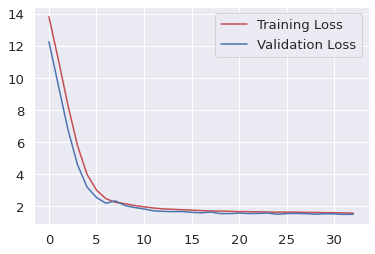

In [ ]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

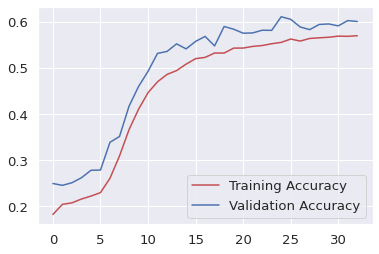

In [ ]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

Model evaluation

In [ ]:
#test_generator = testgen.flow(X_test, y_test, batch_size=32)
loss = model.evaluate(X_test, y_test) 
print("Test Accuracy: " + str(loss[1]))

113/113 [==============================] - 1s 9ms/step - loss: 1.4831 - accuracy: 0.6186
Test Accuracy: 0.6185566782951355


##Test Data Prediction

In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 1s 7ms/step


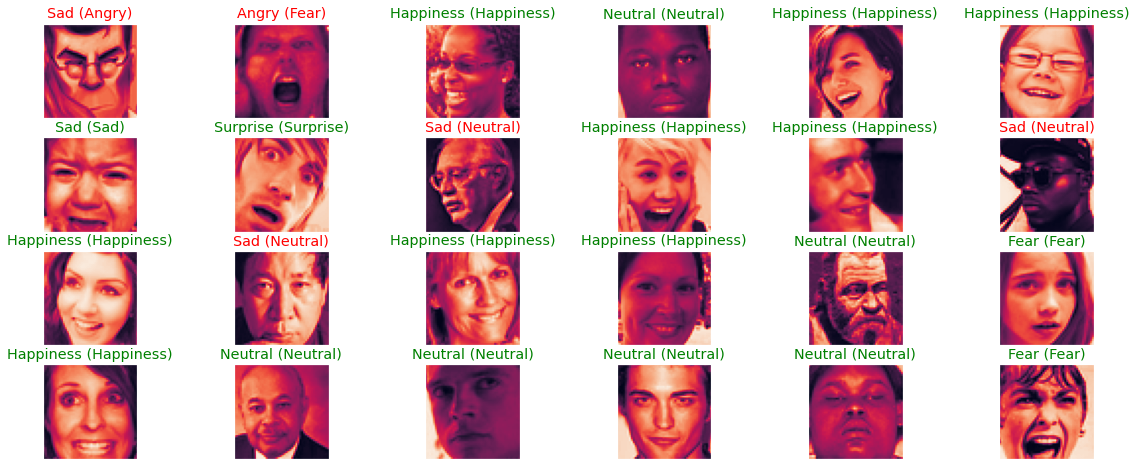

In [ ]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

**Confusion Matrix**

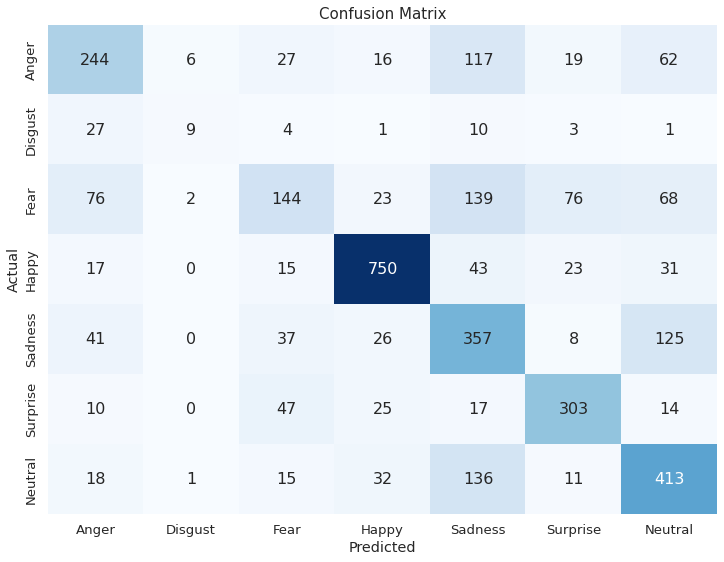

In [ ]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sadness', "Surprise", 'Neutral']

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (12,9))
plt.title('Confusion Matrix', fontsize = 15)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

**Accuracy Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.564     0.497     0.528       491
           1      0.500     0.164     0.247        55
           2      0.498     0.273     0.353       528
           3      0.859     0.853     0.856       879
           4      0.436     0.601     0.505       594
           5      0.684     0.728     0.705       416
           6      0.578     0.660     0.616       626

    accuracy                          0.619      3589
   macro avg      0.588     0.539     0.544      3589
weighted avg      0.621     0.619     0.610      3589



<h2><center><B>--- END of Part 1---</B></center></h2>